In [1]:
# This notebook intends to compare metrics against 
# available validation datasets. The main goal is
# to generate performance curves as well as thresholds
# for the different metrics and events.  

In [2]:
import yaml
import math
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import itertools
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Select event & define paths to data

In [3]:
EVENT_NAME = 'chile_fire_2024' 
TRACK_IDX = 0
METRIC_IDX = 6 # options [0, 1, 2, 3, 4, 5, 6] for [CUSUM_PROB_MAX, CUSUM_VH, LOG_RATIO, MAHALANOBIS_1D_MAX, MAHALANOBIS_2D, MAHALANOBIS_VH, TRANSFORMER] respectively


In [4]:
dist_events_dir = Path('/u/aurora-r0/cmarshak/dist-s1-events')
dist_metrics_dir = Path('/u/aurora-r0/cmarshak/dist-s1-calibration/out_metrics')

print(dist_events_dir, dist_metrics_dir)

/u/aurora-r0/cmarshak/dist-s1-events /u/aurora-r0/cmarshak/dist-s1-calibration/out_metrics


In [5]:
# Read event info
yaml_file = dist_events_dir / f'events/{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 180,
 'post_event_window_days': 100,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'source_id': 'EMSR715 AOI1',
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

In [6]:
# Get date and tracks
EVENT_DATE = event_dict['event_date']
TRACKS = event_dict['rtc_track_numbers']
print('Event date:', EVENT_DATE)
print('Tracks:', TRACKS)

Event date: 2024-02-04
Tracks: [18, 156]


In [7]:
# Event data
EVENT_DATA = dist_events_dir / 'out' / EVENT_NAME
# set up out directory
# OUT_DIR = EVENT_DATA / 'out'
TEMPDIR = Path('./testing')
OUT_DIR = TEMPDIR / 'out_comparison'
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR, OUT_DIR.exists()

(PosixPath('testing/out_comparison'), True)

In [8]:
# Get preprocessed datasets for specified event
RTC_DIR = EVENT_DATA / 'rtc_ts_merged'
DIST_HLS_CM_DIR = EVENT_DATA / 'change_map_dist_hls'
WATER_MASK_DIR = EVENT_DATA / 'water_mask'
VAL_DATA_DIR = EVENT_DATA / 'validation_data'
all([d.exists() for d in [RTC_DIR, DIST_HLS_CM_DIR, WATER_MASK_DIR, VAL_DATA_DIR]])

True

In [9]:
# Get paths to metrics
track_number = f'track{TRACKS[TRACK_IDX]}'
EVENT_METRICS = dist_metrics_dir / EVENT_NAME / track_number 

CUSUM_PROB_MAX = EVENT_METRICS /'cusum_prob_max'
CUSUM_VH = EVENT_METRICS / 'cusum_vh'
LOG_RATIO = EVENT_METRICS / 'log_ratio_vh'
MAHALANOBIS_1D_MAX = EVENT_METRICS / 'mahalanobis_1d_max'
MAHALANOBIS_2D = EVENT_METRICS / 'mahalanobis_2d'
MAHALANOBIS_VH = EVENT_METRICS / 'mahalanobis_vh'
TRANSFORMER = EVENT_METRICS / 'transformer'

METRIC_LIST = [CUSUM_PROB_MAX, CUSUM_VH, LOG_RATIO, MAHALANOBIS_1D_MAX, 
               MAHALANOBIS_2D, MAHALANOBIS_VH, TRANSFORMER]

all([d.exists() for d in METRIC_LIST])


True

### Read validation data

In [10]:
# Read validation data
val_data_paths = list(VAL_DATA_DIR.glob('*.tif'))
aoi_path = [p for p in val_data_paths if 'extent_datamask' in p.stem][0]
val_path = [p for p in val_data_paths if 'extent' not in p.stem][0]

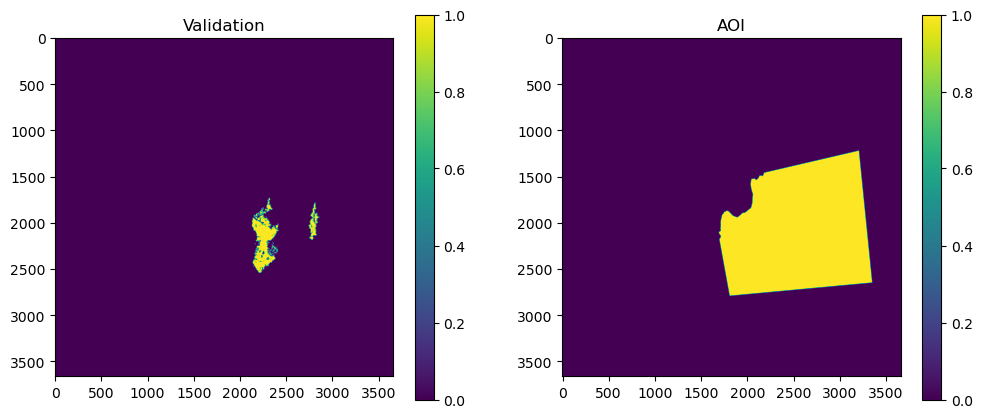

In [11]:
# Visualize validation
with rio.open(val_path) as ds:
    X_val = ds.read(1)
    p_val = ds.profile

with rio.open(aoi_path) as ds:
    X_aoi = ds.read(1)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
cax = ax.imshow(X_val)
ax.set_title("Validation")
cbar = fig.colorbar(cax, orientation='vertical')
ax = fig.add_subplot(1, 2, 2)
cax = ax.imshow(X_aoi)
ax.set_title("AOI")
cbar = fig.colorbar(cax, orientation='vertical')
plt.show()

### Read water mask

In [12]:
# Read water mask
water_path = WATER_MASK_DIR / 'water_mask.tif'
water_path.exists()

True

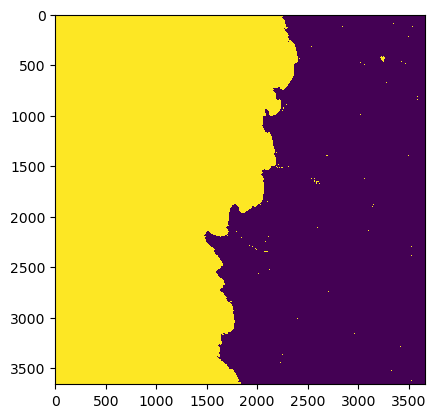

In [13]:
with rio.open(water_path) as ds:
    X_water = ds.read(1)

plt.imshow(X_water, interpolation='none')
plt.show()

### Read Dist-HLS

In [14]:
# Get Dist HLS data
dist_hls_paths = list(DIST_HLS_CM_DIR.glob('*.tif'))
dist_hls_names = [file.stem for file in dist_hls_paths]
dist_hls_names

['dist_hls_confirmed_change_map_veg_first2024-03-06',
 'dist_hls_confirmed_change_map_gen_first2024-03-06',
 'dist_hls_provisional_change_map_veg_first2024-02-05',
 'dist_hls_provisional_change_map_gen_first2024-02-05',
 'dist_hls_confirmed_change_map_veg_first2024-05-10',
 'dist_hls_confirmed_change_map_gen_first2024-05-10']

In [15]:
# Load Dist-HLS
dist_hls_list = []
for file in dist_hls_paths:
    with rio.open(file) as src:
        array = src.read(1)
        array = np.where((array == 0) | (array == 1), array, 0).astype(np.uint8)
        dist_hls_list.append(array)

print(len(dist_hls_list), dist_hls_list[0].shape)

6 (3660, 3660)


### Read metrics

In [16]:
# Events
pre_metric_paths = sorted(list(METRIC_LIST[METRIC_IDX].glob('pre*.tif')))
pre_metric_names = [file.stem for file in pre_metric_paths]
post_metric_paths = sorted(list(METRIC_LIST[METRIC_IDX].glob('post*.tif'))) 
post_metric_names = [file.stem for file in post_metric_paths]

print('Total pre-metrics:', len(pre_metric_paths))
print('Total post-metrics:', len(post_metric_paths))

Total pre-metrics: 2
Total post-metrics: 2


In [17]:
# load arrays
pre_metric_list = []
for file in pre_metric_paths:
    with rio.open(file) as src:
        array = src.read(1)
        pre_metric_list.append(array)

post_metric_list = []
for file in post_metric_paths:
    with rio.open(file) as src:
        array = src.read(1)
        post_metric_list.append(array)

print(len(pre_metric_list), len(post_metric_list))
print(pre_metric_list[0].shape)

2 2
(3660, 3660)


In [18]:
# Create zoom slice
def zoom_slice(mask, buffer_size=100):
    n_rows, n_cols = mask.shape
    rows, cols = np.nonzero(mask)
    # Find the min and max of row and column indices
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()
    # Apply the buffer to the window
    row_min = max(0, row_min - buffer_size)
    row_max = min(n_rows - 1, row_max + buffer_size)
    col_min = max(0, col_min - buffer_size)
    col_max = min(n_cols - 1, col_max + buffer_size)
    # create slice 
    slice = np.s_[row_min:row_max + 1, col_min:col_max + 1]

    return slice


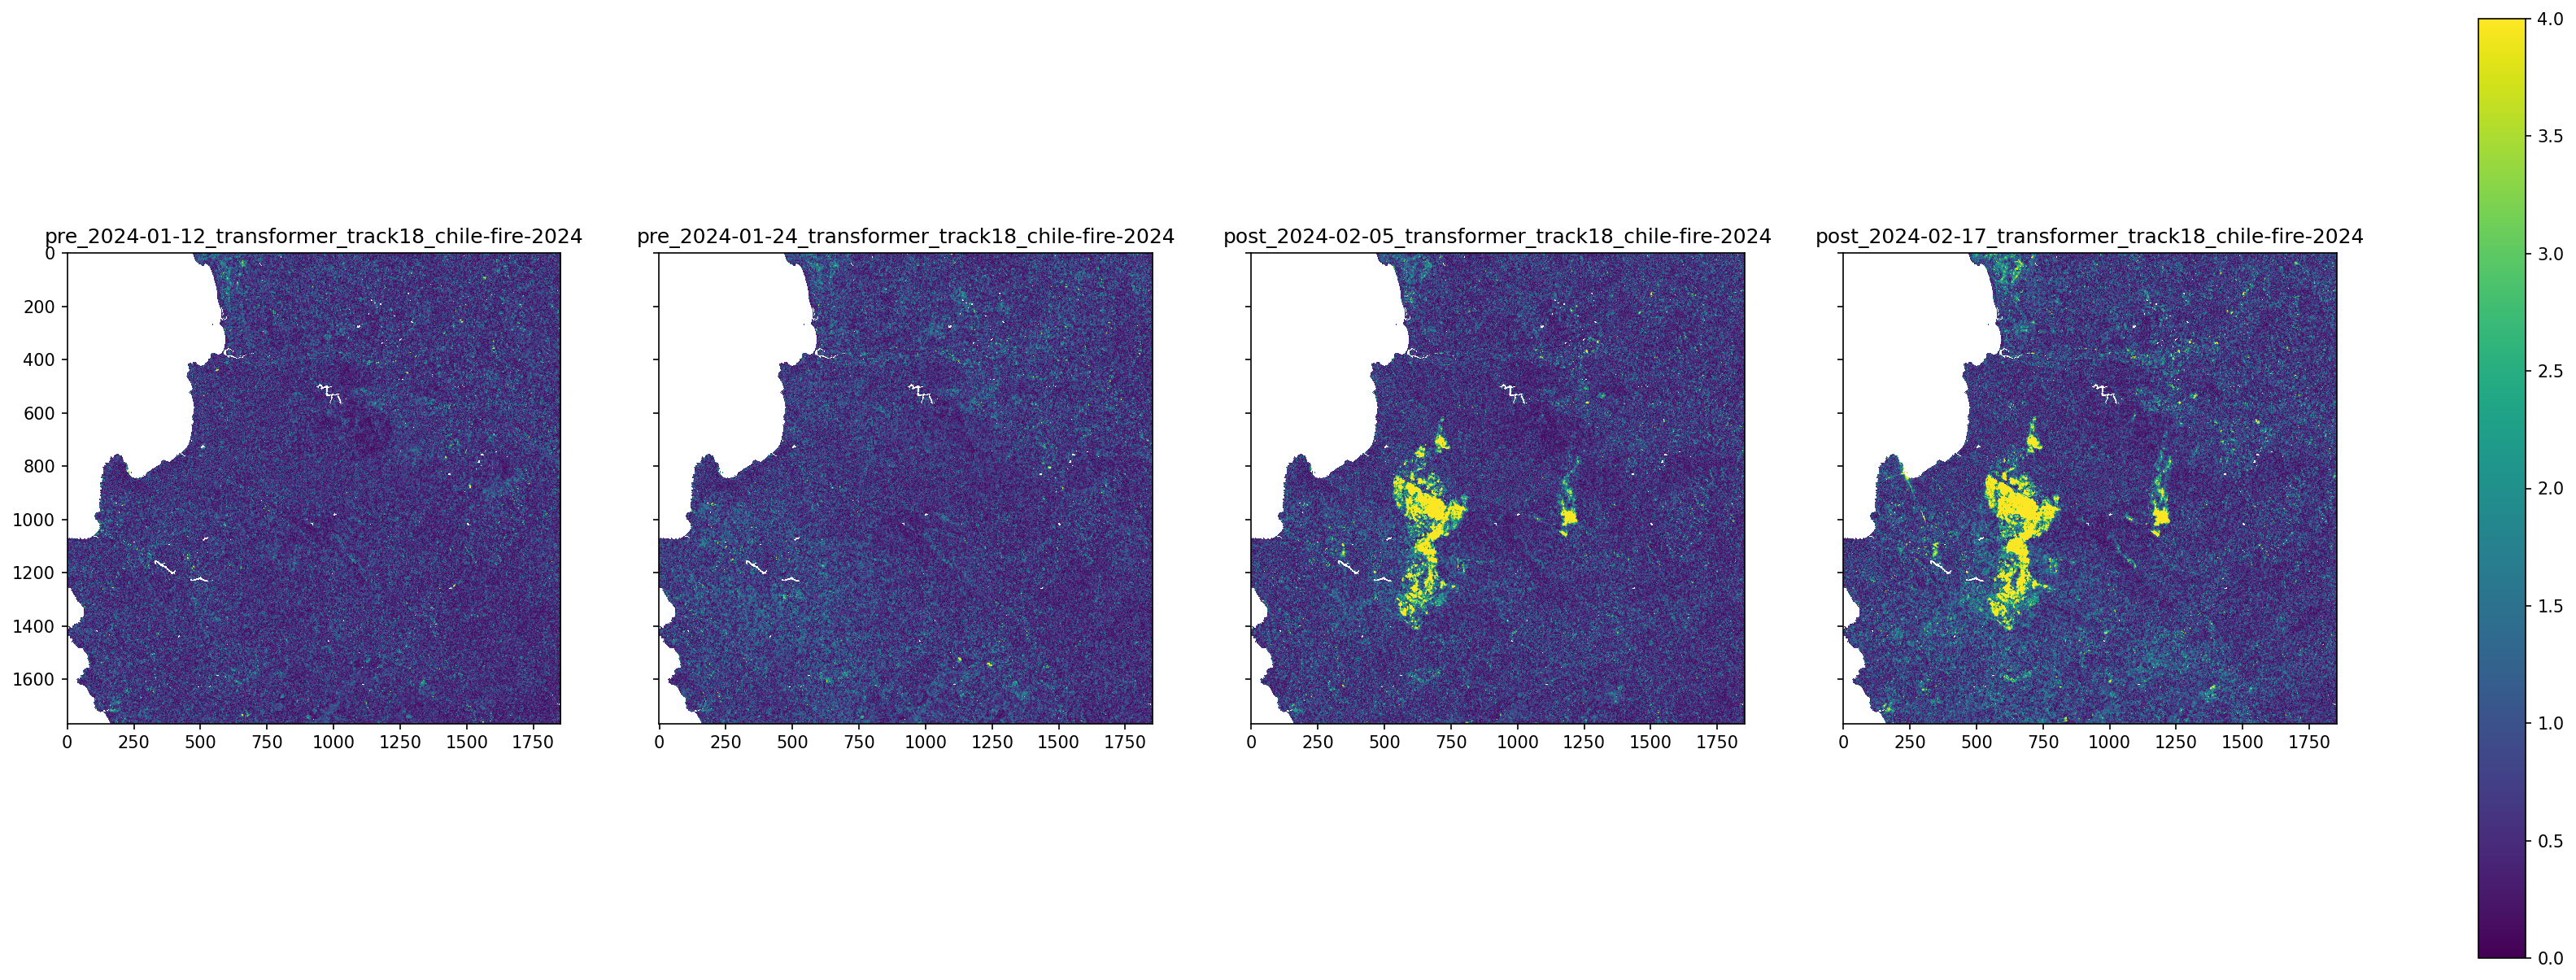

In [19]:
s = zoom_slice(X_aoi.astype(bool) & (~np.isnan(post_metric_list[0])))
metrics = pre_metric_list + post_metric_list  # Combine pre- and post-metrics
metric_names = pre_metric_names + post_metric_names  # Combine names

if METRIC_IDX == 0 or METRIC_IDX == 1:
    # adjust colorbar
    vmin = 0
    vmax = 1
else:
    vmin = 0
    vmax = 4

N = len(metrics)

fig, axs = plt.subplots(1, N, figsize=(10 + N * 5, 10), dpi=150, sharey=True)

if N == 1:
    axs = [axs]

for ax, met, mn in zip(axs, metrics, metric_names):
    im = ax.imshow(met[s], vmin=vmin, vmax=vmax, interpolation='none')
    ax.set_title(mn)

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()


### Compare metrics against validation

In [20]:
def make_aoi_mask(metric, aoi_region):
    '''
    AOI for validation 
    '''
    aoi_mask = aoi_region.astype(bool) & (~np.isnan(metric))

    return aoi_mask


def make_aoi_mask_multiple(metrics, aoi_region):
    '''
    Create an AOI mask for validation that intersects NaNs across multiple metric arrays.
    
    Parameters:
    metrics (list of arrays): List of metric arrays to find the intersection of NaNs.
    aoi_region (array): AOI region as a mask array.
    
    Returns:
    aoi_mask: Combined mask where NaNs intersect across all metrics and lie within AOI region.
    '''
    
    # Get NaN masks for all metric arrays
    nan_masks = [np.isnan(metric) for metric in metrics]
    
    # Find intersection of NaNs across all arrays
    intersect_nan_mask = np.logical_or.reduce(nan_masks)
    
    # Create the combined AOI mask
    # aoi_mask = aoi_region.astype(bool) & (~intersect_nan_mask)
    aoi_mask = aoi_region.astype(bool) & (~intersect_nan_mask) & (~np.isnan(aoi_region))

    
    return aoi_mask


def jaccard_similarity(a, b):
    """
    Compute the Jaccard similarity coefficient (intersect-over-union) of two boolean
    arrays.
    Parameters
    ----------
    a, b : numpy array
        The input binary masks.
    Returns
    -------
    J : float
        The Jaccard similarity coefficient of the two inputs.
    """
    a = np.asanyarray(a, dtype=np.bool_)
    b = np.asanyarray(b, dtype=np.bool_)

    return np.sum(a & b) / np.sum(a | b)


def jacc_vs_thresh(metric_arr, validation_arr, thresholds, sample_size=200):
    '''
    Calculate Jaccard coefficients between thresholded metrics and validation
    '''
    subsampled_thresholds = np.linspace(thresholds.min(), thresholds.max(), sample_size)

    jaccard_results = [
        (jaccard_similarity(metric_arr > thresh, validation_arr), thresh)
        for thresh in subsampled_thresholds
    ]
    
    jaccard_coefficients, jacc_thresh = zip(*jaccard_results)

    return list(jaccard_coefficients), list(jacc_thresh)

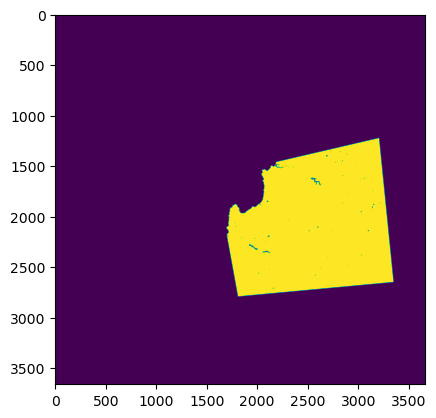

In [21]:
# get curves for each case
aoi_mask = make_aoi_mask_multiple(post_metric_list + pre_metric_list, X_aoi)
plt.imshow(aoi_mask)

In [22]:
# Concat metric arrays for both pre and post metrics
metric_aoi_con = np.concatenate([lst[aoi_mask] for lst in post_metric_list + pre_metric_list], axis=0)

# Concat validation arrays, adding change_val or np.zeros depending on whether it's a post or pre metric
change_val = X_val[aoi_mask]
change_val_con = np.concatenate(
    [change_val if i < len(post_metric_list) else np.zeros(change_val.shape) for i in range(len(post_metric_list) + len(pre_metric_list))],
    axis=0
)


In [23]:
# Calculate precision recall and f1score
precisions, recalls, thresholds = precision_recall_curve(change_val_con, metric_aoi_con)
f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-7)
k_max = np.argmax(f1_scores)
f1_max = f1_scores[k_max]

# Get dist-hls f1 score
dist_hls_f1_v_val = f1_score(change_val, dist_hls_list[len(dist_hls_list)-1][aoi_mask])

In [24]:
# Calculate ROC curve
fprs, tprs, _ = roc_curve(change_val_con, metric_aoi_con)
auc = roc_auc_score(change_val_con, metric_aoi_con)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_213089/4223934292.py:12: SyntaxWarning: invalid escape sequence '\m'
  axs[0].annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + 0.01, precisions[k_max] + 0.01),
/tmp/ipykernel_213089/4223934292.py:20: SyntaxWarning: invalid escape sequence '\m'
  axs[1].annotate(f'$\max(F_1)=${f1_max:1.2f}', (thresholds[k_max] + 0.02, f1_scores[k_max] + 0.01),


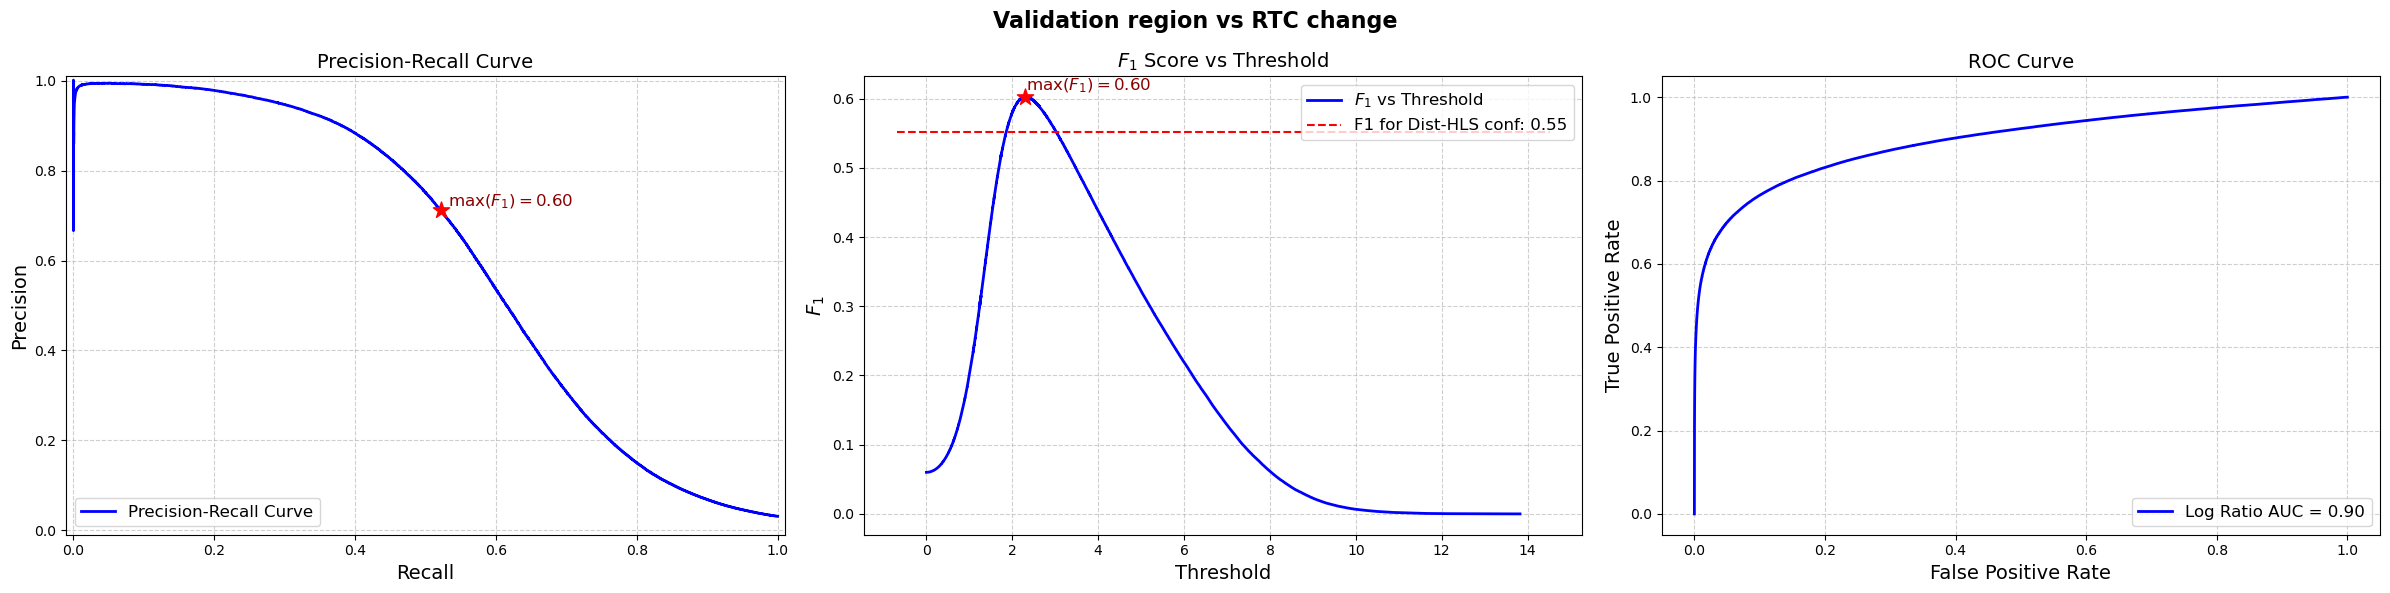

In [25]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  

# Plot 1: Precision-Recall Curve
axs[0].plot(recalls[:-1], precisions[:-1], label='Precision-Recall Curve', linewidth=2, color='blue')
axs[0].set_xlim(-0.01, 1.01)
axs[0].set_ylim(-0.01, 1.01)
axs[0].set_ylabel('Precision', fontsize=14)
axs[0].set_xlabel('Recall', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].scatter(recalls[k_max], precisions[k_max], marker='*', c='red', s=150, zorder=3)
axs[0].annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + 0.01, precisions[k_max] + 0.01), 
                fontsize=12, color='darkred')
axs[0].set_title('Precision-Recall Curve', fontsize=14)
axs[0].legend(loc='lower left', fontsize=12)

# Plot 2: F1 Score vs Threshold
axs[1].plot(thresholds, f1_scores[:-1], label='$F_1$ vs Threshold', linewidth=2, color='blue')
axs[1].scatter(thresholds[k_max], f1_scores[k_max], marker='*', c='red', s=150, zorder=3)
axs[1].annotate(f'$\max(F_1)=${f1_max:1.2f}', (thresholds[k_max] + 0.02, f1_scores[k_max] + 0.01),
                fontsize=12, color='darkred')
axs[1].set_title('$F_1$ Score vs Threshold', fontsize=14)
axs[1].set_ylabel('$F_1$', fontsize=14)
axs[1].set_xlabel('Threshold', fontsize=14)
axs[1].grid(True, linestyle='--', alpha=0.6)
xlim = axs[1].get_xlim()
axs[1].hlines(dist_hls_f1_v_val, *xlim, color='red', linestyles='--', label=f'F1 for Dist-HLS conf: {dist_hls_f1_v_val:1.2f}')
axs[1].legend(loc='best', fontsize=12)
axs[1].set_xlim(axs[1].get_xlim())  # Ensure consistent x-limits

# Plot 3: ROC Curve
axs[2].plot(fprs, tprs, label=f'Log Ratio AUC = {auc:1.2f}', linewidth=2, color='blue')
axs[2].set_xlabel('False Positive Rate', fontsize=14)
axs[2].set_ylabel('True Positive Rate', fontsize=14)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].legend(loc='lower right', fontsize=12)
axs[2].set_title('ROC Curve', fontsize=14)

plt.suptitle('Validation region vs RTC change', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


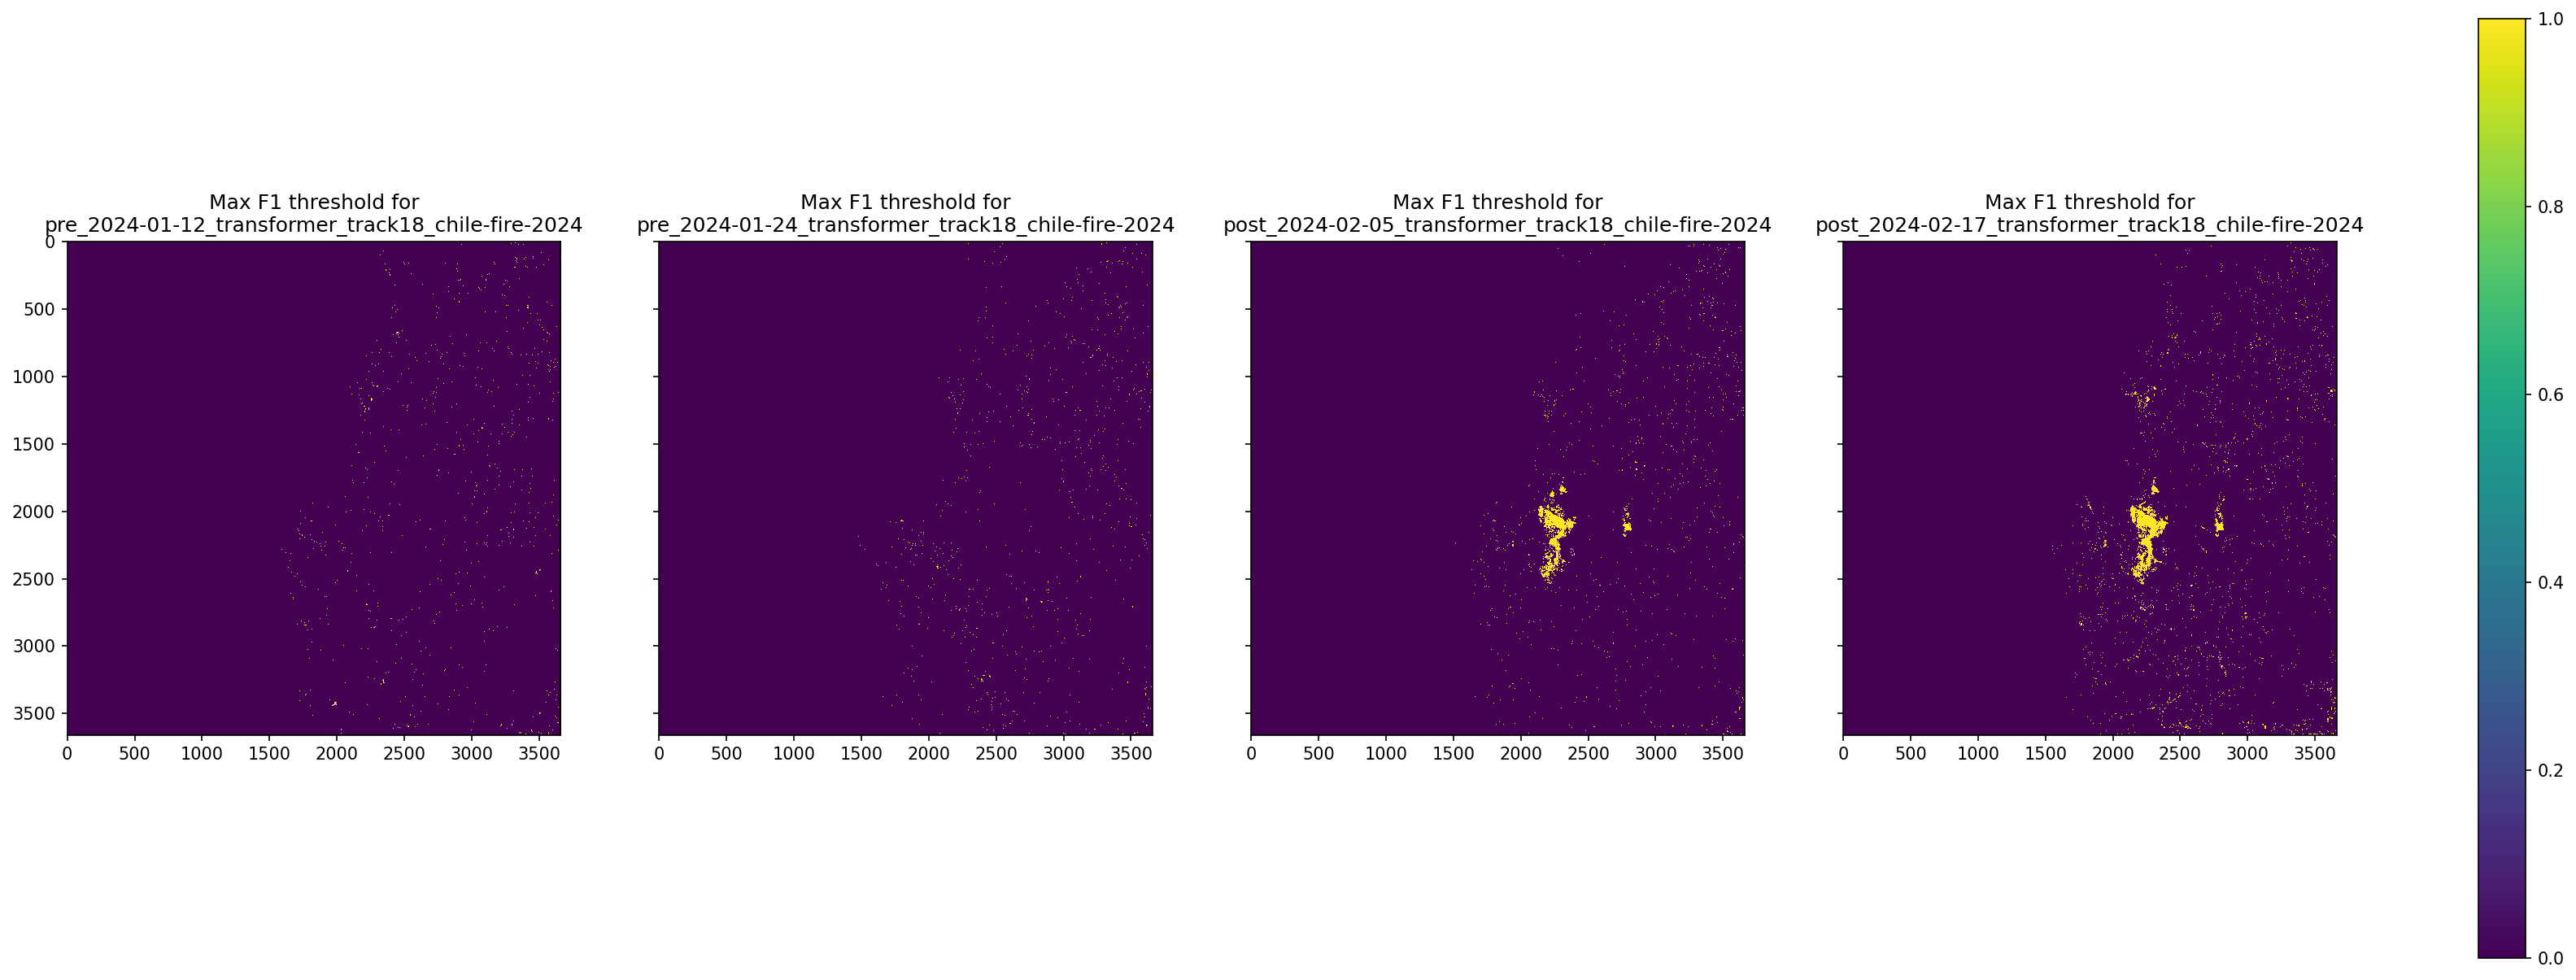

In [26]:
# Create thresholded metrics 
thresholded = [(met > thresholds[k_max]) for met in pre_metric_list + post_metric_list]
# Get thresholded names
thresholded_names = [f"Max F1 threshold for\n{name}" for name in metric_names]

N = len(thresholded)

fig, axs = plt.subplots(1, N, figsize=(10 + N * 5, 10), dpi=150, sharey=True)

# If there's only one thresholded metric
if N == 1:
    axs = [axs]

for ax, met, mn in zip(axs, thresholded, thresholded_names):
    im = ax.imshow(met, vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn)

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()


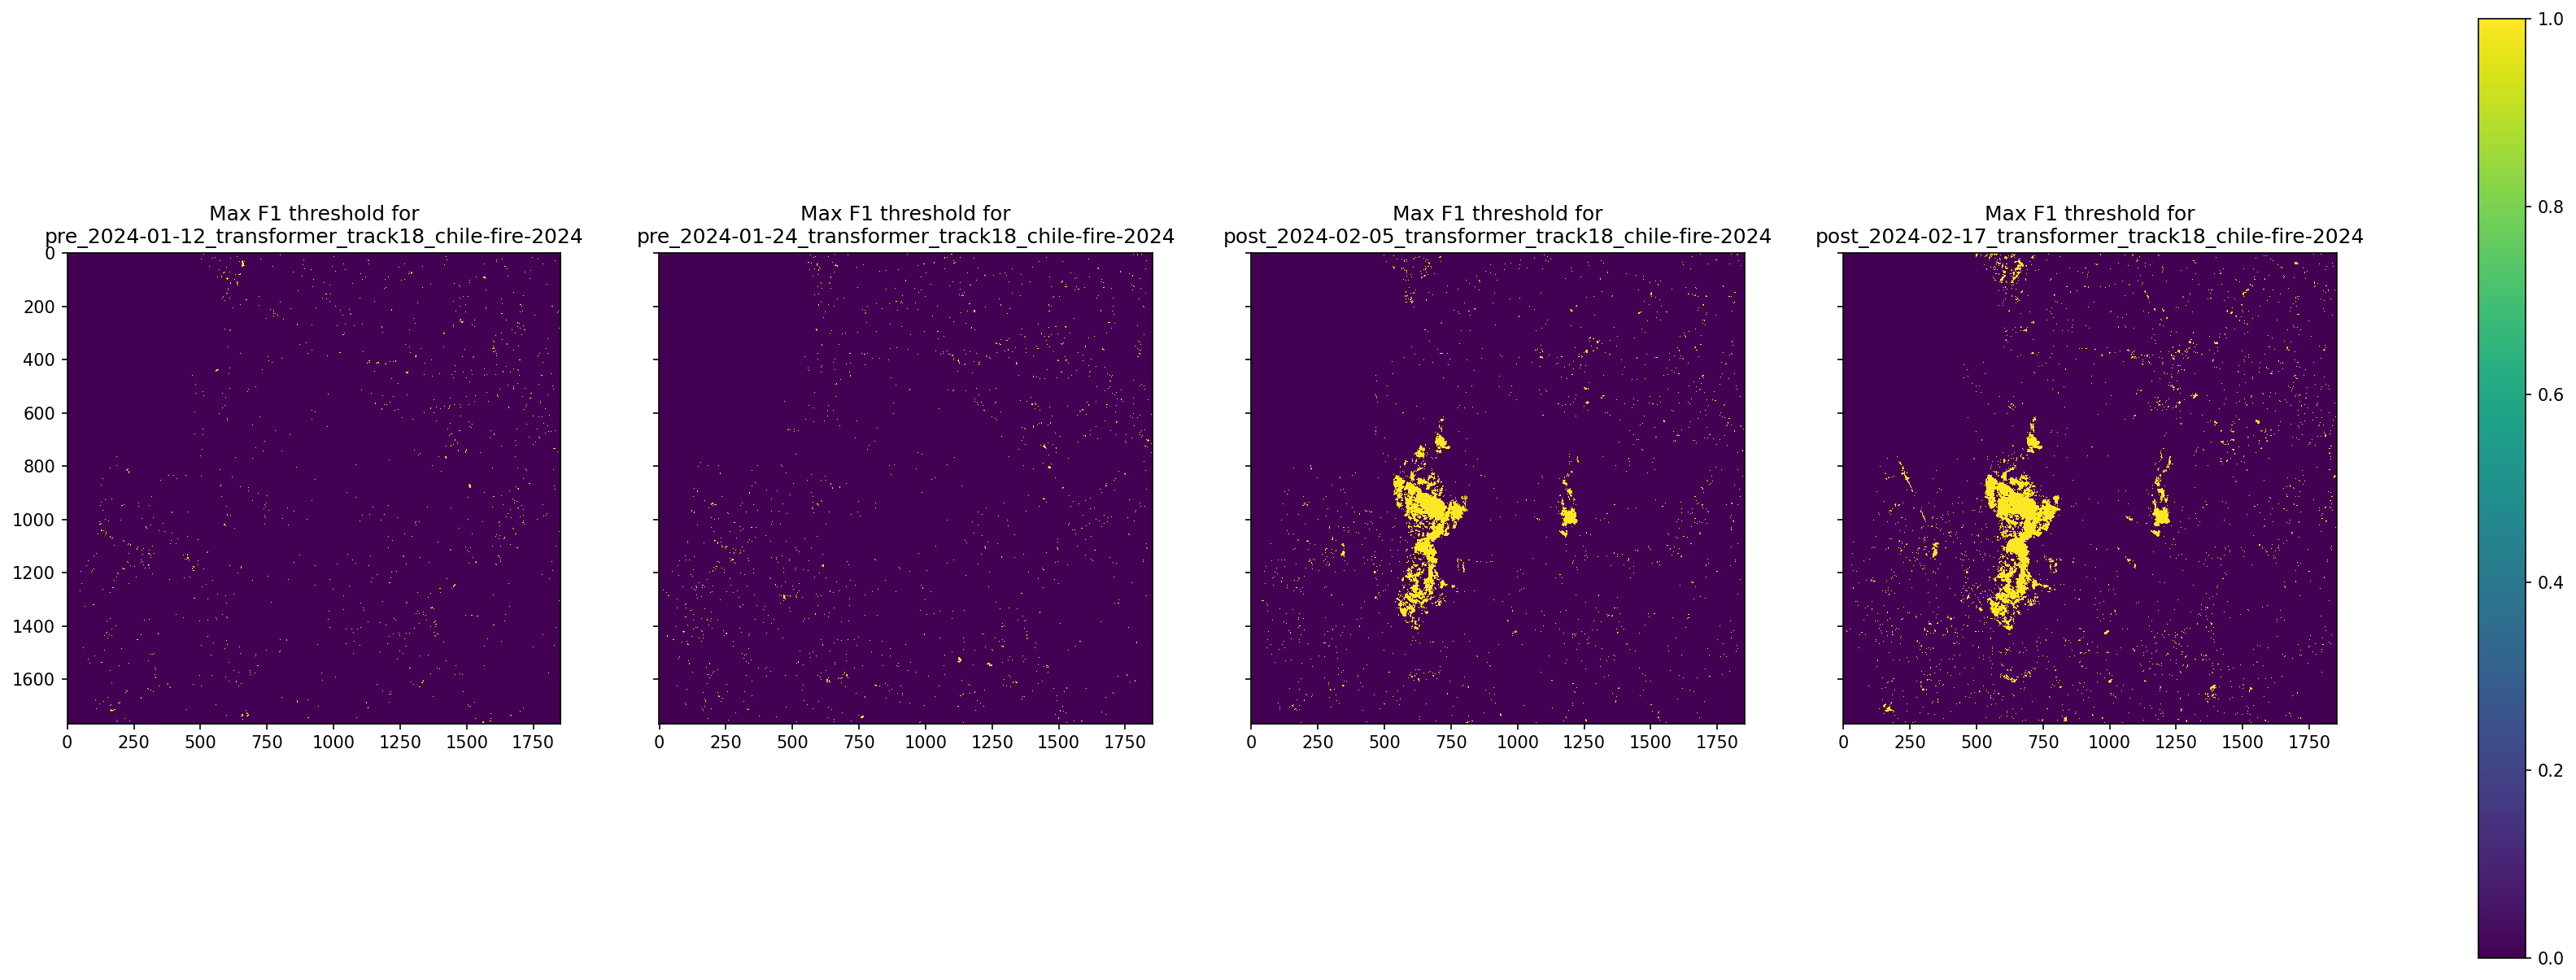

In [27]:
# visualize thresholded metrics zoomed in to validation region
# create thresholded metrics 
thresholded = [(met > thresholds[k_max]) for met in pre_metric_list + post_metric_list]
# get thresholded names
thresholded_names = [f"Max F1 threshold for\n{name}" for name in metric_names]

N = len(thresholded)

fig, axs = plt.subplots(1, N, figsize=(10 + N * 5, 10), dpi=150, sharey=True)

# If there's only one thresholded metric
if N == 1:
    axs = [axs]

for ax, met, mn in zip(axs, thresholded, thresholded_names):
    im = ax.imshow(met[s], vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn)

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

### Jaccard coefficients 

In [28]:
# concatenate arrays 
concat_post_metric = np.concatenate(post_metric_list, axis=0)
concat_val = np.concatenate([X_val] * len(post_metric_list), axis=0)
# get jaccard coefficients 
jaccard_coeffs, thresh_subset = jacc_vs_thresh(concat_post_metric, concat_val, thresholds)
# find the maximum jaccard coefficient
max_jaccard = np.max(jaccard_coeffs)
max_index = np.argmax(jaccard_coeffs)
max_thresh = thresh_subset[max_index]


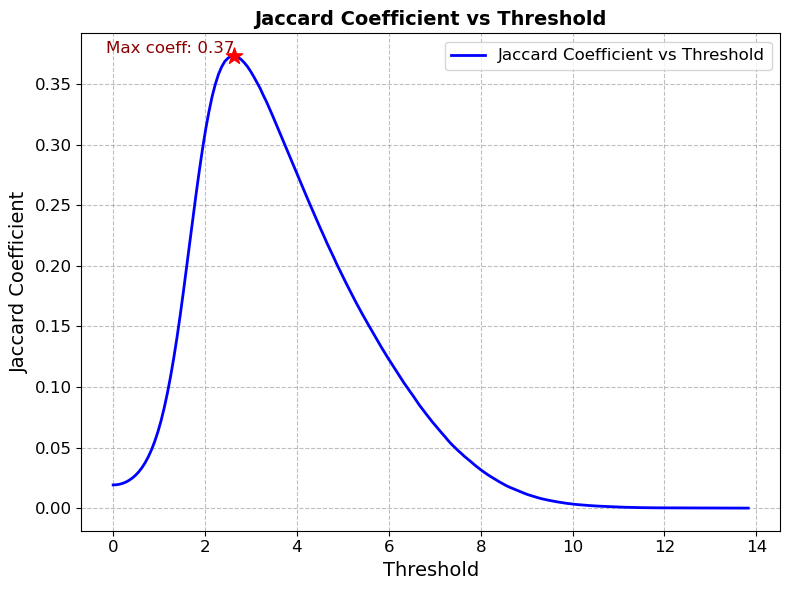

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(thresh_subset, jaccard_coeffs, label=f'Jaccard Coefficient vs Threshold',  color='blue', linewidth=2)
plt.title('Jaccard Coefficient vs Threshold', fontsize=14, weight='bold')
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Jaccard Coefficient', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.scatter(max_thresh, max_jaccard, marker='*', c='red', s=150, zorder=3)
plt.text(max_thresh, max_jaccard, f'Max coeff: {max_jaccard:.2f}', color='darkred', 
         fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

### Compare with Dist-HLS

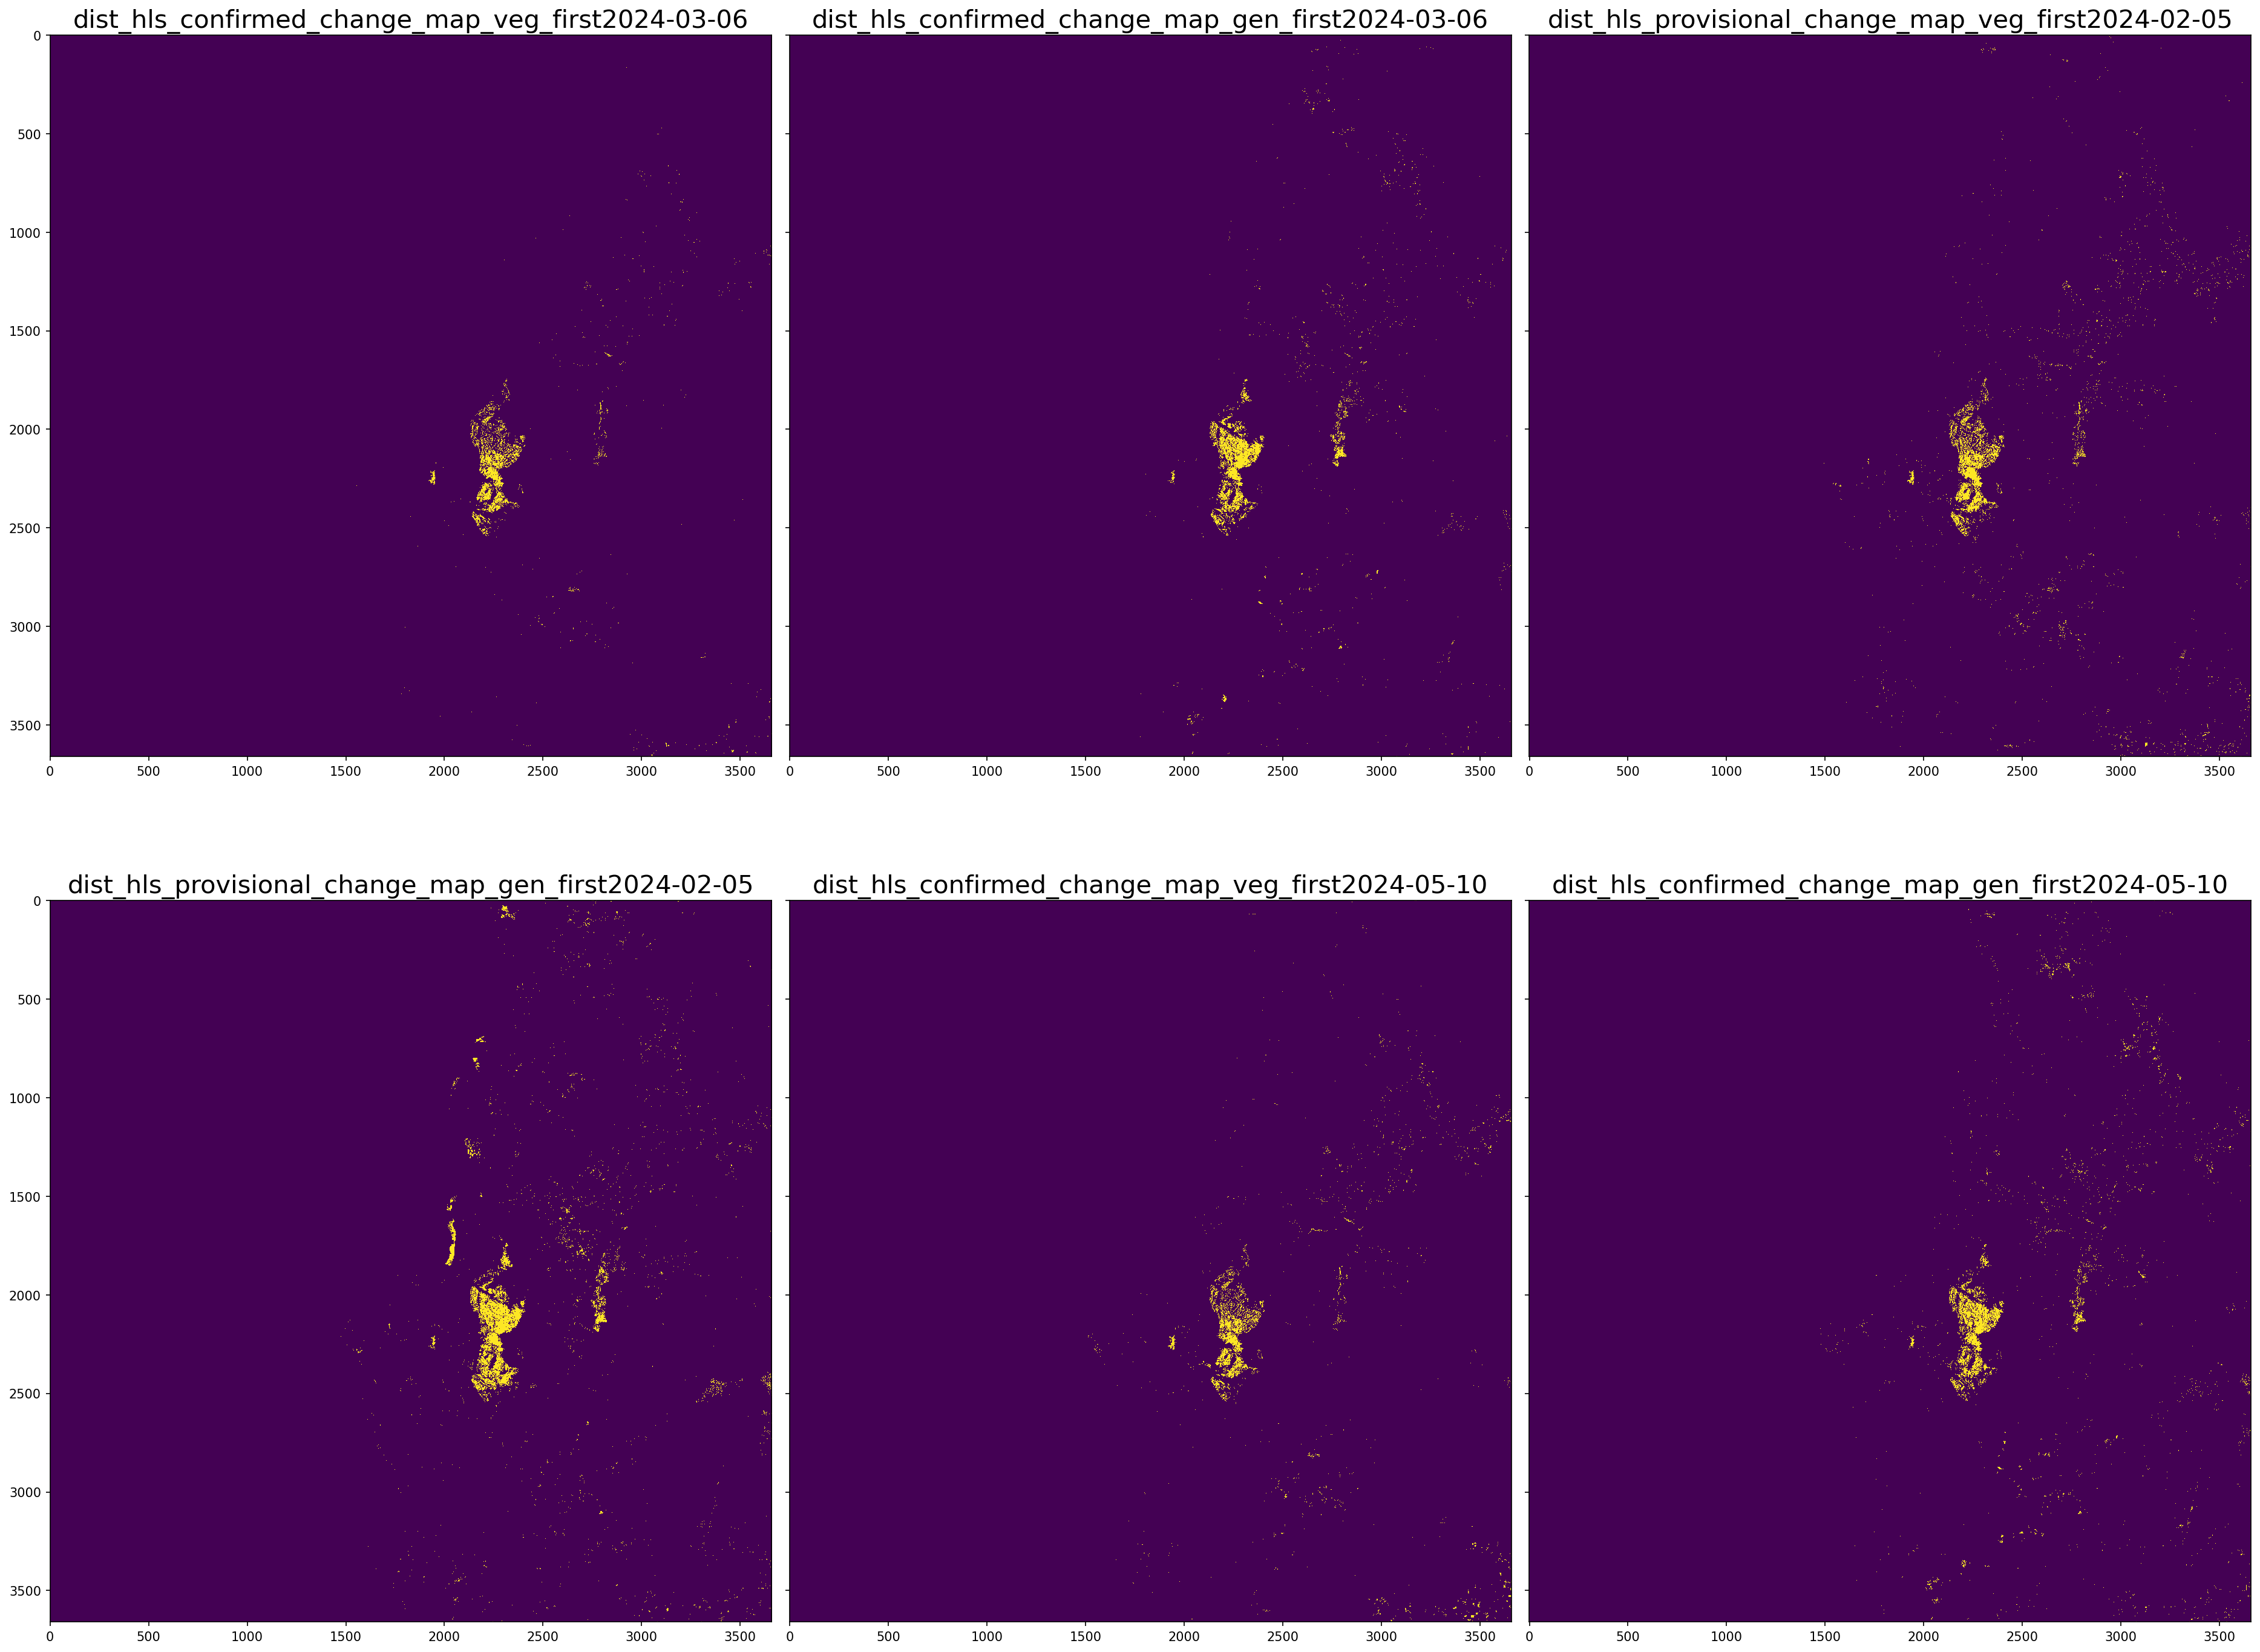

In [30]:
# Visualize dist-hls
N = len(dist_hls_list)
ncols = math.ceil(N / 2) 
nrows = 2 

fig, axs = plt.subplots(nrows, ncols, figsize=(10 + ncols * 5, 10 + nrows * 5), dpi=150, sharey=True)

# Flatten axs if N is odd or if N doesn't divide equally into two rows
axs = axs.flatten()

for ax, met, mn in zip(axs, dist_hls_list, dist_hls_names):
    im = ax.imshow(met, vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn, fontsize=20)

plt.tight_layout()
plt.show()


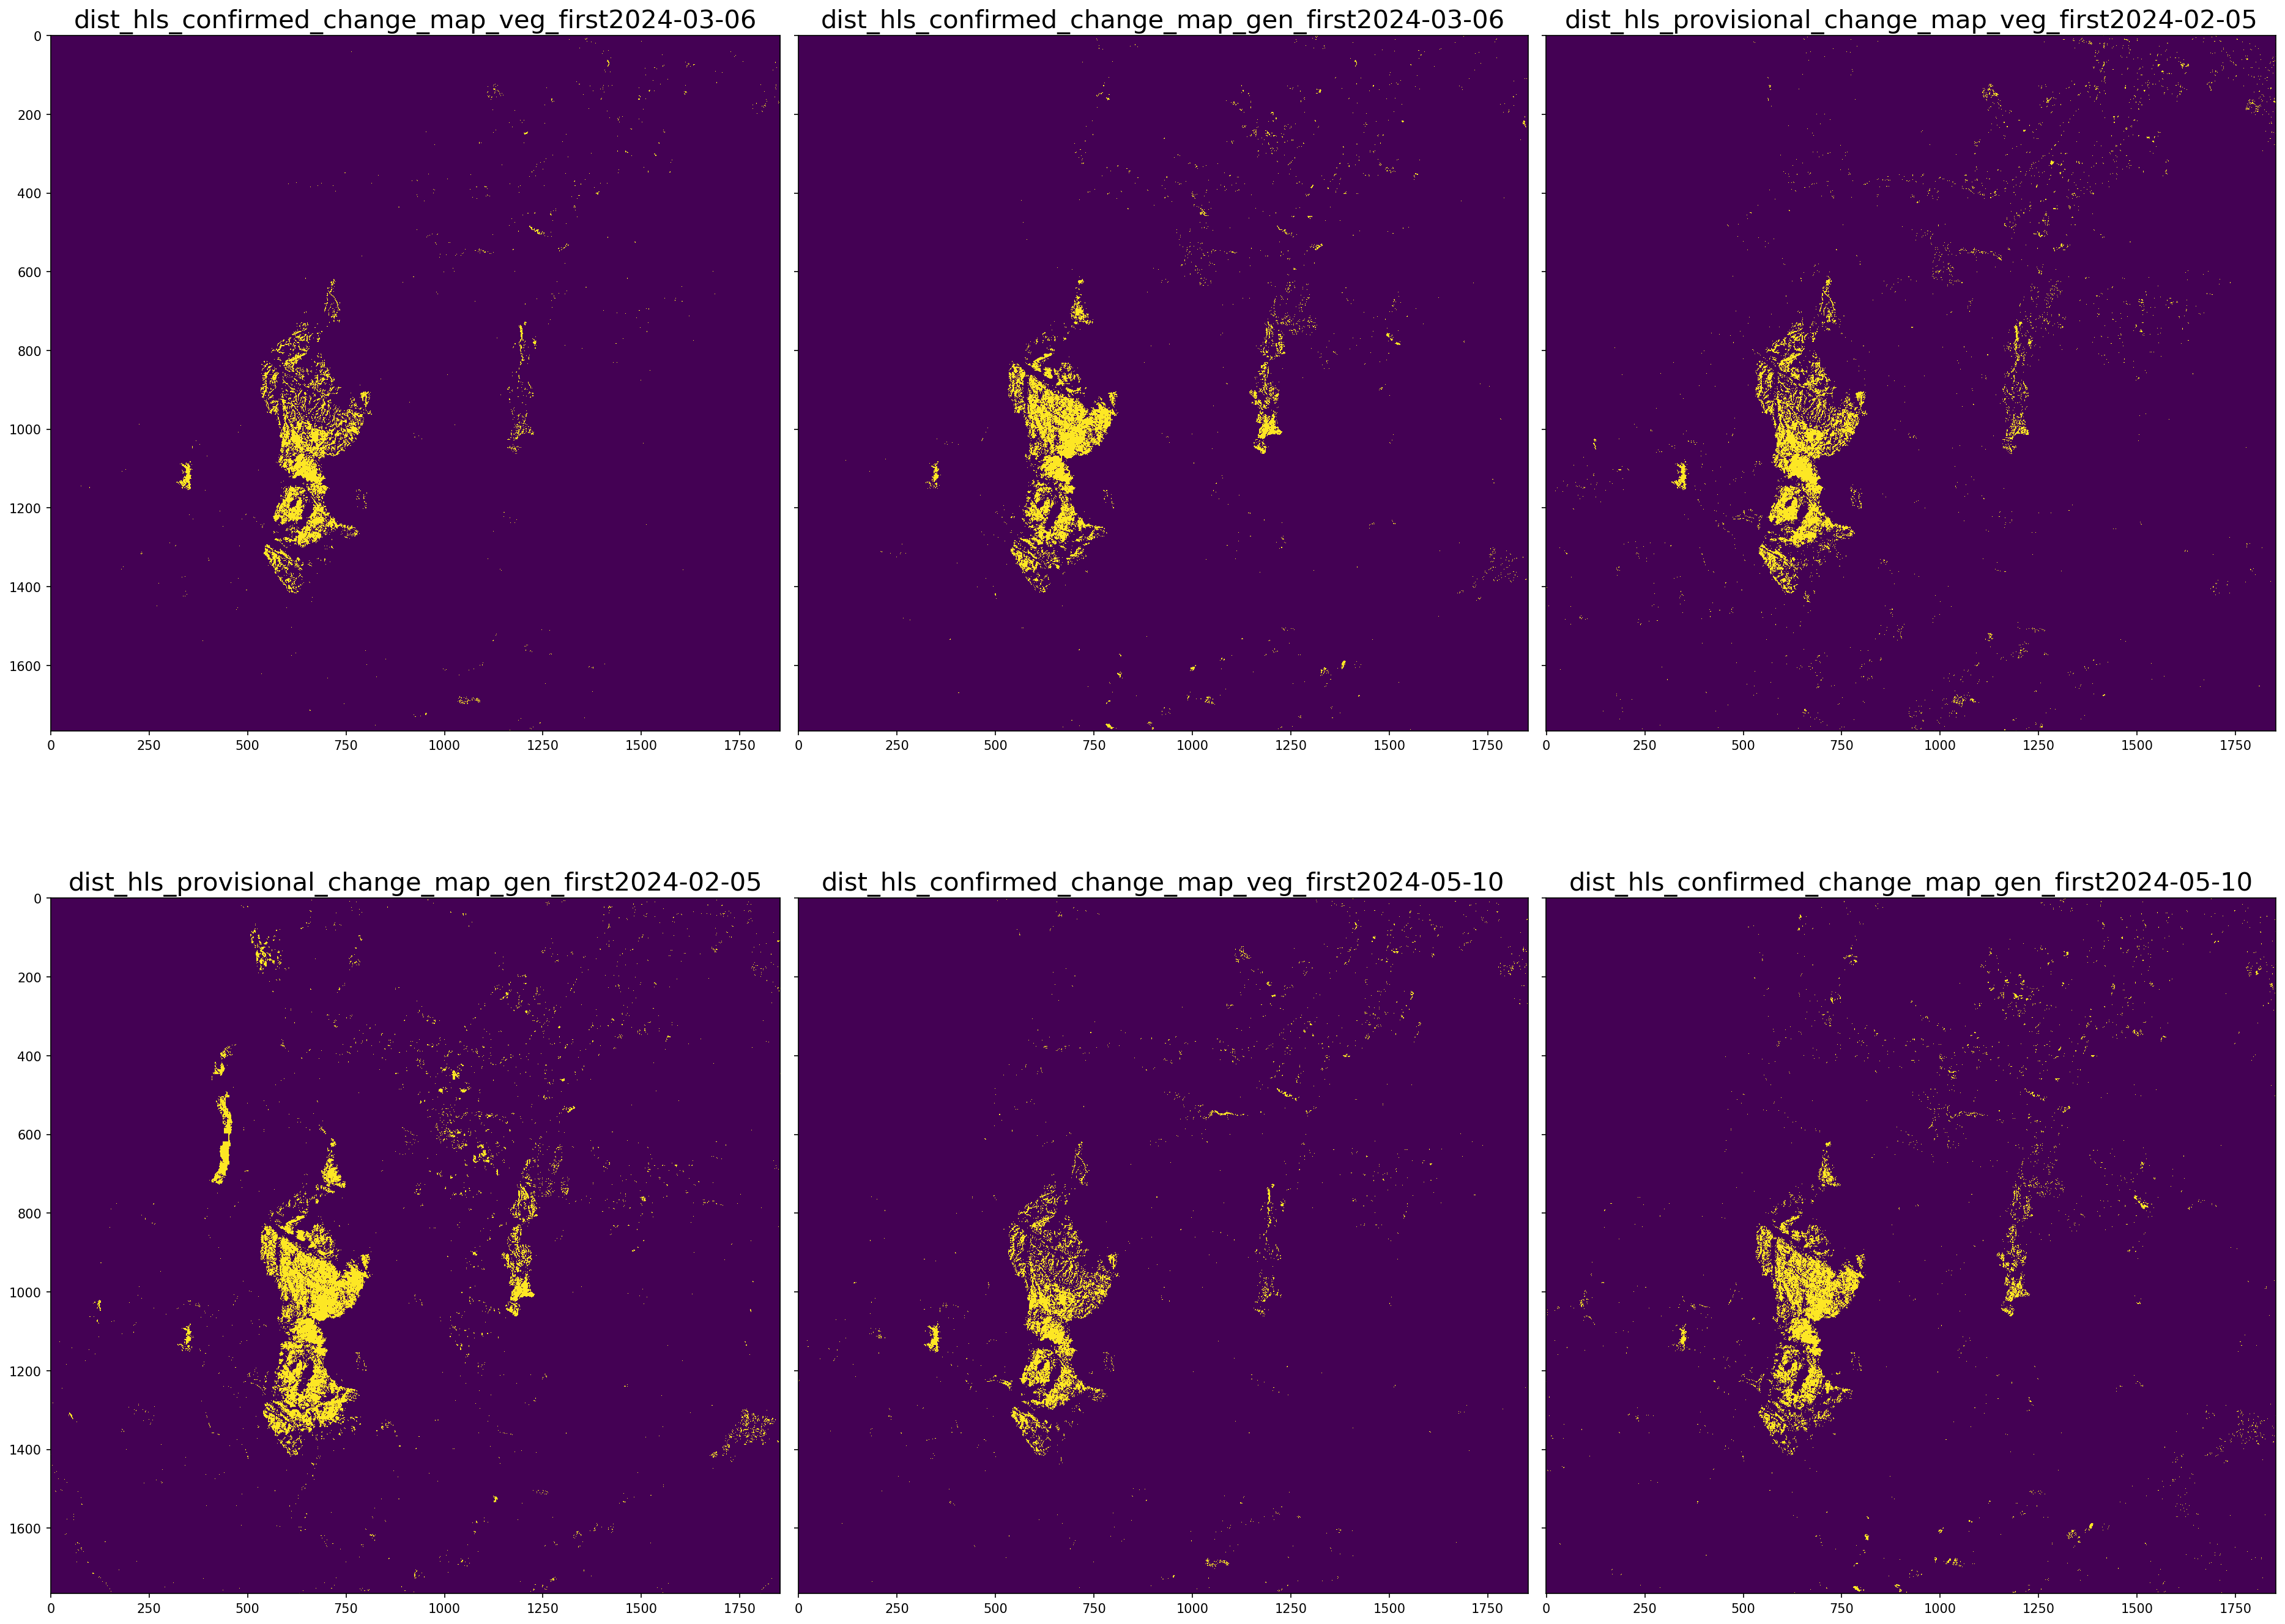

In [31]:
# Dist-HLS overview zoom
N = len(dist_hls_list)
ncols = math.ceil(N / 2) 
nrows = 2 

fig, axs = plt.subplots(nrows, ncols, figsize=(10 + ncols * 5, 10 + nrows * 5), dpi=150, sharey=True)

# Flatten axs if N is odd or if N doesn't divide equally into two rows
axs = axs.flatten()

for ax, met, mn in zip(axs, dist_hls_list, dist_hls_names):
    im = ax.imshow(met[s], vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn, fontsize=20)

plt.tight_layout()
plt.show()

In [32]:
def plot_precision_recall_curves(dist_hls_list, dist_hls_names, metric_list, metric_names):
    # Initialize empty DataFrame
    f1_scores_df = pd.DataFrame(columns=['dist_hls_name', 'metric_name', 'f1_max'])
    
    # Loop over each metric and process all dist_hls_list items
    for metric_idx, metric in enumerate(metric_list):
        metric_name = metric_names[metric_idx]
        
        # Create a new figure for each metric
        plt.figure(figsize=(12, 5))
        
        # Define line styles and colors for better distinction
        colors = plt.cm.Dark2(np.linspace(0, 1, len(dist_hls_list)))
        line_styles = itertools.cycle(['-', '--', '-.', ':'])
        
        for i, dist_arr in enumerate(dist_hls_list):
            X_dist_cm = dist_arr

            dist_hls_mask = ~np.isnan(metric)
            metric_dist = metric[dist_hls_mask]
            change_dist = X_dist_cm[dist_hls_mask]

            # Calculate precision-recall curve
            precisions, recalls, thresholds = precision_recall_curve(change_dist, metric_dist)

            # Calculate F1 score and find max
            f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-7)
            k_max = np.argmax(f1_scores)
            f1_max = f1_scores[k_max]

            # Collect data into DataFrame
            temp_df = pd.DataFrame([{
                'dist_hls_name': dist_hls_names[i],
                'metric_name': metric_name,
                'f1_max': round(f1_max, 4)
            }])

            # Concatenate temp_df to f1_scores_df
            f1_scores_df = pd.concat([f1_scores_df, temp_df], ignore_index=True)

            # Plot precision-recall curve with distinct color and style
            plt.plot(recalls[:-1], precisions[:-1], 
                     label=f'{dist_hls_names[i]}', 
                     color=colors[i], linestyle=next(line_styles), lw=2)

            # Highlight max F1 score
            plt.scatter(recalls[k_max], precisions[k_max], marker='*', c='red', zorder=2, s=100)
            plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', 
                         (recalls[k_max] + 0.01, precisions[k_max] + 0.01),
                         fontsize=12, color=colors[i])

        # Add labels, title, and limits
        plt.xlim(-0.01, 1.01)
        plt.ylim(-0.01, 1.01)
        plt.ylabel('Precision', fontsize=14)
        plt.xlabel('Recall', fontsize=14)
        plt.title(f'Precision-Recall Curves for {metric_name}', fontsize=12, weight='bold')

        # Adjust the legend location dynamically to place it in an empty region
        plt.legend(loc='upper right', fontsize=12, frameon=True)
        
        # Tighten the layout
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        
        # Show the plot for this metric
        plt.show()

    # Return the concatenated DataFrame with all F1 scores
    return f1_scores_df


<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_213089/3673783747.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.annotate(f'$\max(F_1)=${f1_max:1.2f}',


/tmp/ipykernel_213089/3673783747.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_scores_df = pd.concat([f1_scores_df, temp_df], ignore_index=True)


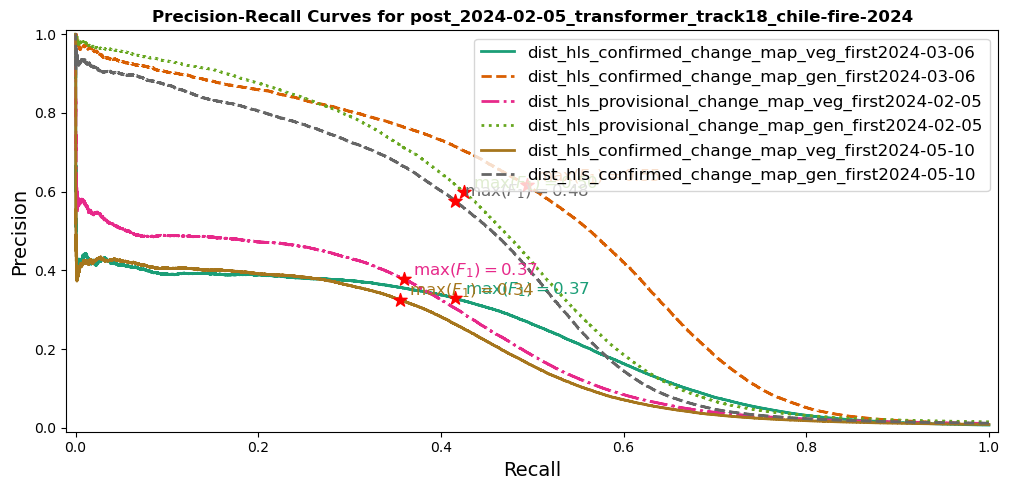

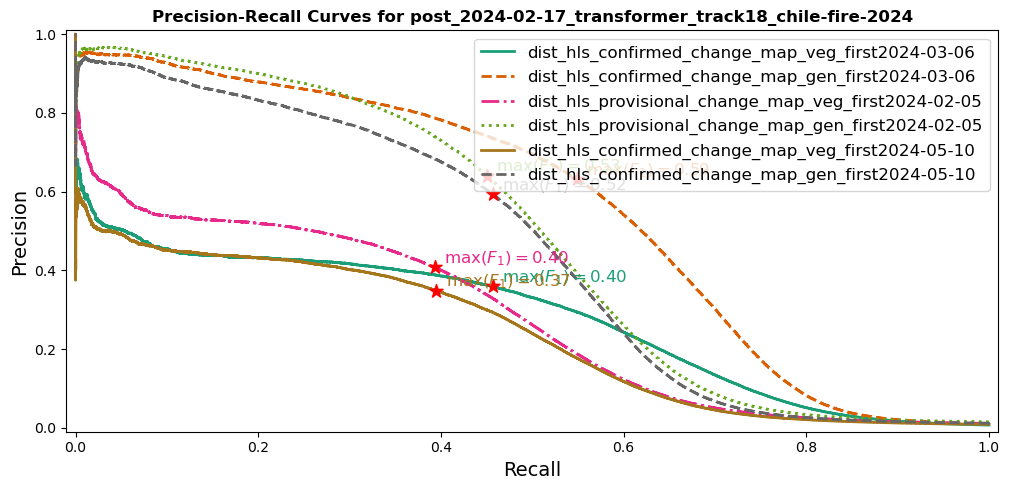

In [33]:
dist_hls_vs_metric_f1scores = plot_precision_recall_curves(dist_hls_list, dist_hls_names,
                                                           post_metric_list, post_metric_names)

In [34]:
dist_hls_vs_metric_f1scores

dist_hls_name  \
0   dist_hls_confirmed_change_map_veg_first2024-03-06   
1   dist_hls_confirmed_change_map_gen_first2024-03-06   
2   dist_hls_provisional_change_map_veg_first2024-...   
3   dist_hls_provisional_change_map_gen_first2024-...   
4   dist_hls_confirmed_change_map_veg_first2024-05-10   
5   dist_hls_confirmed_change_map_gen_first2024-05-10   
6   dist_hls_confirmed_change_map_veg_first2024-03-06   
7   dist_hls_confirmed_change_map_gen_first2024-03-06   
8   dist_hls_provisional_change_map_veg_first2024-...   
9   dist_hls_provisional_change_map_gen_first2024-...   
10  dist_hls_confirmed_change_map_veg_first2024-05-10   
11  dist_hls_confirmed_change_map_gen_first2024-05-10   

                                          metric_name  f1_max  
0   post_2024-02-05_transformer_track18_chile-fire...  0.3676  
1   post_2024-02-05_transformer_track18_chile-fire...  0.5487  
2   post_2024-02-05_transformer_track18_chile-fire...  0.3687  
3   post_2024-02-05_transformer_track18_chile-fire...  0.4974  
4   post_2024-02-05_transformer_track18_chile-fire...  0.3399  
5   post_2024-02-05_transformer_track18_chile-fire...  0.4833  
6   post_2024-02-17_transformer_track18_chile-fire...  0.4021  
7   post_2024-02-17_transformer_track18_chile-fire...  0.5879  
8   post_2024-02-17_transformer_track18_chile-fire...  0.4005  
9   post_2024-02-17_transformer_track18_chile-fire...  0.5293  
10  post_2024-02-17_transformer_track18_chile-fire...  0.3706  
11  post_2024-02-17_transformer_track18_chile-fire...  0.5166

### Dist-HLS Comparison plots

In [35]:
# Create thresholded metrics 
post_thresholded = [(met > thresholds[k_max]) for met in post_metric_list]
# Get thresholded names
post_thresholded_names = [f"Max F1 threshold for\n{name}" for name in post_metric_names]

In [36]:
def compare_agreement(dist_list, dist_list_name, metric_threshold, metric_threshold_name, mask, sample=np.s_[:]):
    ''' 
    Loops over a list of metric0 arrays and compares them to metric1,
    plotting the differences in a single figure with 2 rows.
    '''
    
    # Determine the number of columns (based on the length of metric0_list)
    num_metrics = len(dist_list)
    num_cols = (num_metrics + 1) // 2  # Adjust for 2 rows

    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_cols, figsize=(num_cols * 5, 10))
    axes = axes.flatten()  # Flatten axes array to easily iterate over

    cmap = plt.get_cmap('Spectral')
    values = [-1, 0, 1]
    bnds = [values[0] - .5] + [v + .5 for v in values]

    # Create a normalization object
    norm = mcolors.BoundaryNorm(boundaries=bnds, ncolors=cmap.N, clip=True)
    perc_0_list = []  # List to store the index of the metric0 with the highest percentage of 0 pixels

    for idx, dist_arr in enumerate(dist_list):
        m0 = dist_arr.astype(float)
        m1 = metric_threshold.astype(float)
        
        diff = m0 - m1
        diff[mask] = np.nan

        # Estimate the percentage of pixels with value 0
        valid_pixels = np.isfinite(diff)  # Only consider non-NaN pixels
        total_pixels = np.sum(valid_pixels)
        # perc_neg1 = np.sum(diff[valid_pixels] == -1) / total_pixels * 100
        perc_0 = np.sum(diff[valid_pixels] == 0) / total_pixels * 100
        # perc_1 = np.sum(diff[valid_pixels] == 1) / total_pixels * 100
        
        # Track the index of the highest percentage of 0 pixels
        perc_0_list.append(perc_0)

        # Plot on the respective subplot axis
        ax = axes[idx]
        im = ax.imshow(diff[sample], interpolation='none', vmin=-1, vmax=1, cmap='Spectral')

        # Add titles and labels for each subplot
        mn0 = f'{dist_list_name[idx]}'
        ax.set_title(f'Agreement of {np.round(perc_0, 3)}%:\n{mn0}', fontsize=10)
    
    # Get the index of the metric0 with the highest percentage of 0 pixels
    # highest_perc_0_index = np.argmax(perc_0_list)

    # Add a colorbar common to all subplots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=values, boundaries=bnds)
    # labels = [f'{metric1_name} change but not {metric0_name}', 'Agree', f'{metric0_name} change but not {metric1_name}']
    labels = [f'Threshold change but not Dist-HLS', 'Agree', f'Dist-HLS change but not threshold']
    cbar.ax.set_yticklabels(labels)

    # Add a main title to the entire figure
    fig.suptitle(f'Difference: Dist-HLS vs {metric_threshold_name}', fontsize=12, weight='bold')

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit colorbar
    plt.show()

    return perc_0_list

/tmp/ipykernel_213089/678240962.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit colorbar


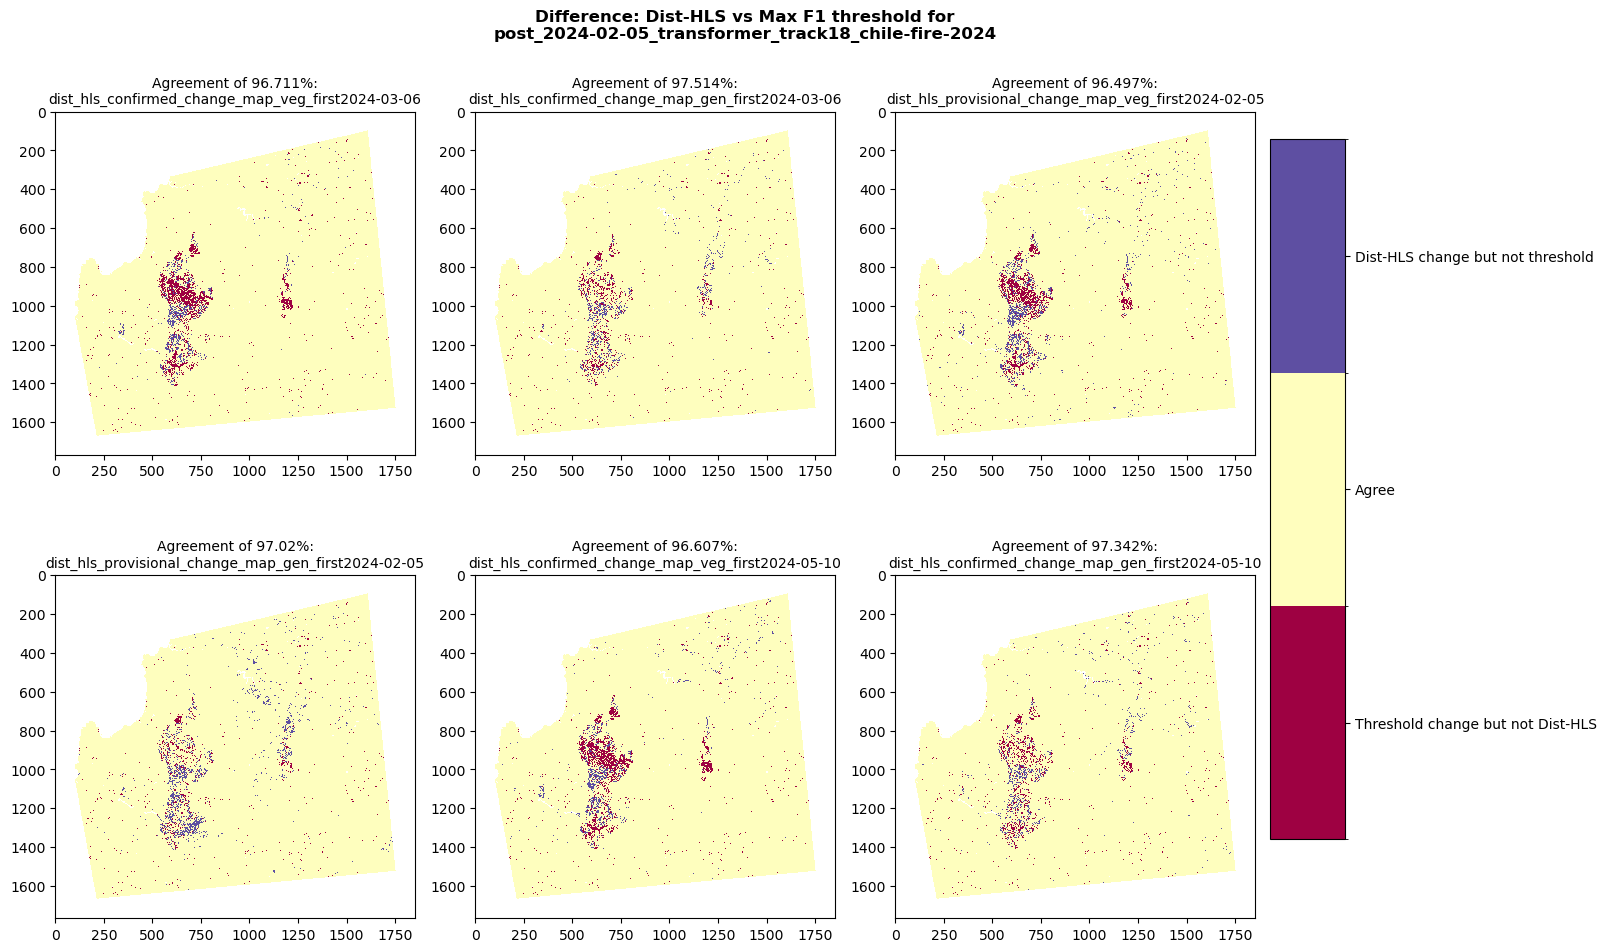

/tmp/ipykernel_213089/678240962.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit colorbar


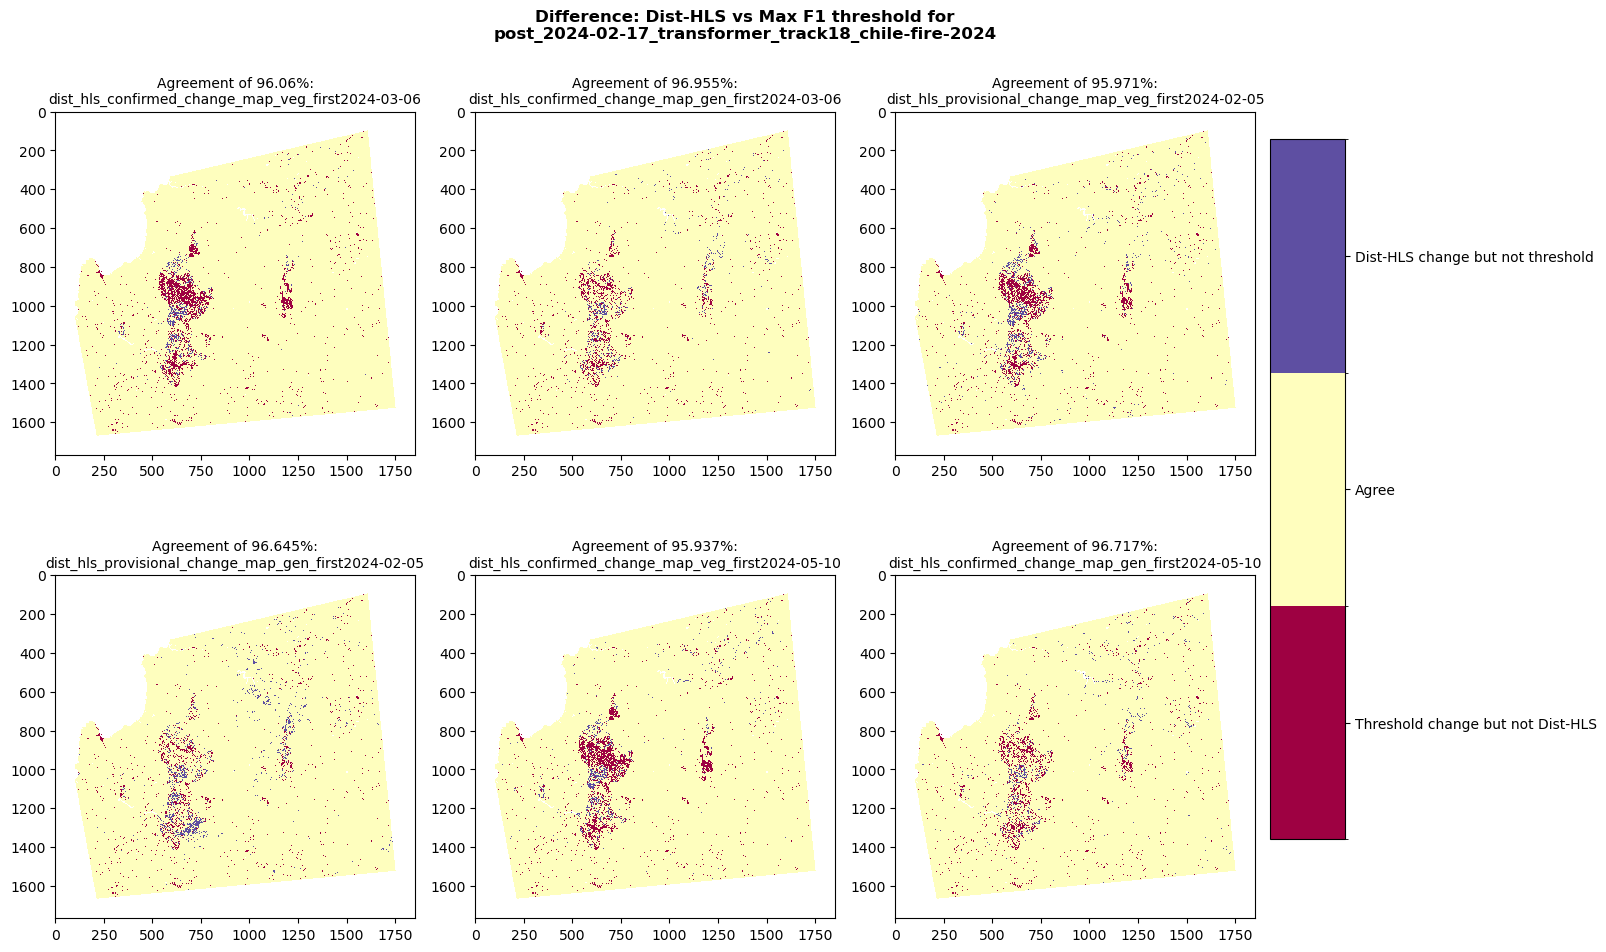

In [37]:
dist_hls_agreement_list = []
for idx, post_array in enumerate(post_thresholded):
    best_agreement = compare_agreement(dist_hls_list, dist_hls_names, 
                                       post_array, post_thresholded_names[idx], 
                                       ~aoi_mask, sample=s)
    dist_hls_agreement_list.append(best_agreement)

In [38]:
### Metric vs Dist-HLS comparison curves 
# we use the ones with best agreement for the comparison.  

In [39]:
# select the dist-hls arrays that had the highes maxf1 score and comparethem against the metric 
selected_dist_hls_arrays = []
grouped_dist_f1scores = dist_hls_vs_metric_f1scores.groupby('metric_name')
for metric_name , group in grouped_dist_f1scores:
    max_f1_row = group.loc[group['f1_max'].idxmax()]

    # Extract the corresponding index from the dist_hls_names
    dist_hls_name = max_f1_row['dist_hls_name']
    original_index = dist_hls_names.index(dist_hls_name)
    selected_dist_hls_arrays.append(original_index)

print(selected_dist_hls_arrays)

[1, 1]


In [40]:
# Select the best agreement DIST-HLS arrays and concatenate for comparison
# Extract the arrays using the selected indices
selected_dist_hls_arrays = [dist_hls_list[i] for i in selected_dist_hls_arrays]
print(len(selected_dist_hls_arrays), selected_dist_hls_arrays[0].shape)
# Concatenate the selected dist-hls arrays along axis=0
X_dist_cm = np.concatenate(selected_dist_hls_arrays, axis=0)
print(X_dist_cm.shape)
# concatenate metric and create mask
post_metric_con = np.concatenate(post_metric_list, axis=0)
print(post_metric_con.shape)
dist_hls_mask = ~np.isnan(post_metric_con)

2 (3660, 3660)
(7320, 3660)
(7320, 3660)


In [41]:
metric_dist_hls = post_metric_con[dist_hls_mask]
pre_metric_con = np.concatenate(pre_metric_list, axis=0)
metric_dist_hls_pre = pre_metric_con[dist_hls_mask]
metric_dist_hls_con = np.concatenate([metric_dist_hls, metric_dist_hls_pre], axis=0)
nan_mask = ~np.isnan(metric_dist_hls_con)
metric_dist_hls_con = metric_dist_hls_con[nan_mask]
print(metric_dist_hls_con.shape)

change_dist_hls = X_dist_cm[dist_hls_mask]
change_dist_hls_pre = np.zeros(change_dist_hls.shape)
change_dist_hls_con = np.concatenate([change_dist_hls, change_dist_hls_pre], axis=0)
change_dist_hls_con = change_dist_hls_con[nan_mask]
print(change_dist_hls_con.shape)

precisions_dishls, recalls_disthls, thresholds_disthls = precision_recall_curve(change_dist_hls_con, metric_dist_hls_con)

f1_scores_disthls = 2 * recalls_disthls * precisions_dishls / (recalls_disthls + precisions_dishls + 1e-7)
k_max_dist_hls = np.argmax(f1_scores_disthls)
f1_max_dist_hls = f1_scores_disthls[k_max_dist_hls]

(24941980,)
(24941980,)


In [42]:
# Calculate ROC curve
fprs_disthls, tprs_dist_hls, _ = roc_curve(change_dist_hls_con, metric_dist_hls_con)
auc_disthls = roc_auc_score(change_dist_hls_con, metric_dist_hls_con)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_213089/251533715.py:12: SyntaxWarning: invalid escape sequence '\m'
  axs[0].annotate(f'$\max(F_1)=${f1_max_dist_hls:1.2f}', (recalls_disthls[k_max_dist_hls] + 0.01, precisions_dishls[k_max_dist_hls] + 0.01),
/tmp/ipykernel_213089/251533715.py:20: SyntaxWarning: invalid escape sequence '\m'
  axs[1].annotate(f'$\max(F_1)=${f1_max_dist_hls:1.2f}', (thresholds_disthls[k_max_dist_hls] + 0.02, f1_scores_disthls[k_max_dist_hls] + 0.01),


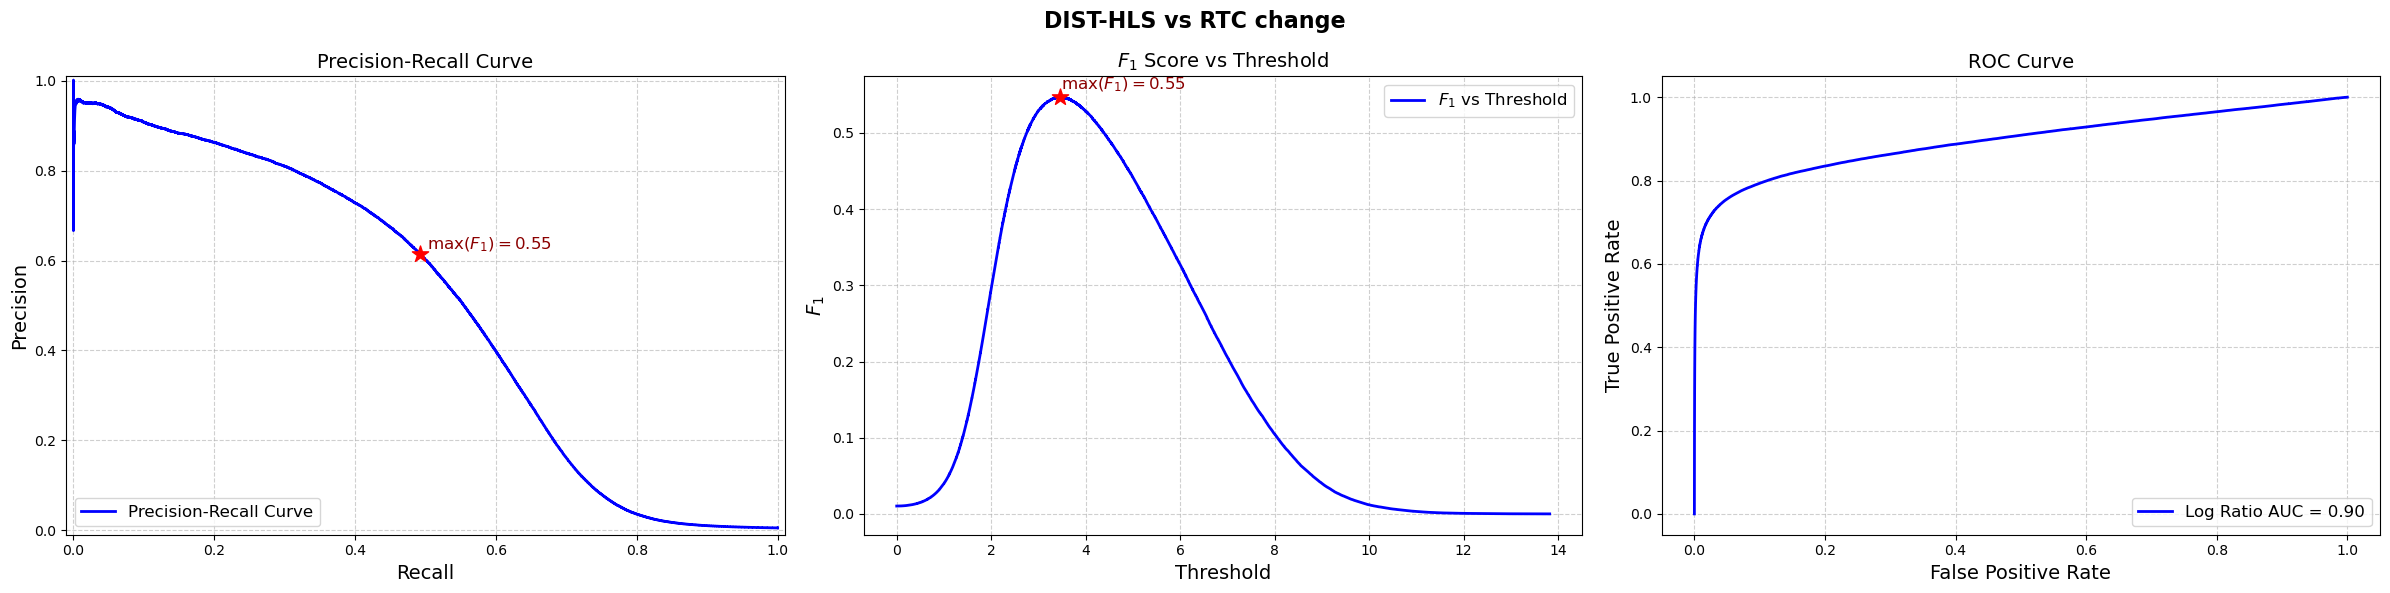

In [43]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  

# Plot 1: Precision-Recall Curve
axs[0].plot(recalls_disthls[:-1], precisions_dishls[:-1], label='Precision-Recall Curve', linewidth=2, color='blue')
axs[0].set_xlim(-0.01, 1.01)
axs[0].set_ylim(-0.01, 1.01)
axs[0].set_ylabel('Precision', fontsize=14)
axs[0].set_xlabel('Recall', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].scatter(recalls_disthls[k_max_dist_hls], precisions_dishls[k_max_dist_hls], marker='*', c='red', s=150, zorder=3)
axs[0].annotate(f'$\max(F_1)=${f1_max_dist_hls:1.2f}', (recalls_disthls[k_max_dist_hls] + 0.01, precisions_dishls[k_max_dist_hls] + 0.01), 
                fontsize=12, color='darkred')
axs[0].set_title('Precision-Recall Curve', fontsize=14)
axs[0].legend(loc='lower left', fontsize=12)

# Plot 2: F1 Score vs Threshold
axs[1].plot(thresholds_disthls, f1_scores_disthls[:-1], label='$F_1$ vs Threshold', linewidth=2, color='blue')
axs[1].scatter(thresholds_disthls[k_max_dist_hls], f1_scores_disthls[k_max_dist_hls], marker='*', c='red', s=150, zorder=3)
axs[1].annotate(f'$\max(F_1)=${f1_max_dist_hls:1.2f}', (thresholds_disthls[k_max_dist_hls] + 0.02, f1_scores_disthls[k_max_dist_hls] + 0.01),
                fontsize=12, color='darkred')
axs[1].set_title('$F_1$ Score vs Threshold', fontsize=14)
axs[1].set_ylabel('$F_1$', fontsize=14)
axs[1].set_xlabel('Threshold', fontsize=14)
axs[1].grid(True, linestyle='--', alpha=0.6)
xlim = axs[1].get_xlim()
axs[1].legend(loc='best', fontsize=12)
axs[1].set_xlim(axs[1].get_xlim())  # Ensure consistent x-limits

# Plot 3: ROC Curve
axs[2].plot(fprs_disthls, tprs_dist_hls, label=f'Log Ratio AUC = {auc_disthls:1.2f}', linewidth=2, color='blue')
axs[2].set_xlabel('False Positive Rate', fontsize=14)
axs[2].set_ylabel('True Positive Rate', fontsize=14)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].legend(loc='lower right', fontsize=12)
axs[2].set_title('ROC Curve', fontsize=14)

plt.suptitle('DIST-HLS vs RTC change', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [44]:
event_table = '/u/aurora-r0/cabrera/opera_dist/testing/dist_s1_events.geojson'
df_events = gpd.read_file(event_table)
event_type = df_events.loc[df_events['event_name'] == EVENT_NAME, 'event_type']
event_type.iloc[0]

'fire'

In [45]:
### Create output dataframe. 

# output table
out_table = {
    'Event_name': [EVENT_NAME],
    'Track_number': [track_number],
    'Event_date':[pd.to_datetime(event_dict['event_date'])],
    'Event_type':[df_events.loc[df_events['event_name'] == EVENT_NAME, 'event_type'].iloc[0]],
    'Metric': [Path(METRIC_LIST[METRIC_IDX]).name],
    'Jaccard_score':max_jaccard,
    'jaccard_thresh':max_thresh,
    'Val_max_f1score':f1_scores[k_max],
    'Val_opt_threshold':thresholds[k_max],
    'Val_prec_recall_auc':auc,
    'Dist_max_f1score':f1_scores_disthls[k_max_dist_hls],
    'Dist_opt_threshold':thresholds_disthls[k_max_dist_hls],
    'Dist_prec_recall_auc':auc_disthls
}

# Create DataFrame
out_table_df = pd.DataFrame(out_table)
out_table_df

Event_name Track_number Event_date Event_type       Metric  \
0  chile_fire_2024      track18 2024-02-04       fire  transformer   

   Jaccard_score  jaccard_thresh  Val_max_f1score  Val_opt_threshold  \
0       0.373143        2.639771         0.602026           2.300601   

   Val_prec_recall_auc  Dist_max_f1score  Dist_opt_threshold  \
0             0.895999          0.546939            3.449461   

   Dist_prec_recall_auc  
0              0.895101

In [46]:
# Export to csv
CSV_OUT_DIR = OUT_DIR / EVENT_NAME 
CSV_OUT_DIR.mkdir(parents=True, exist_ok=True)
csv_file_path = CSV_OUT_DIR / f'comparison_table_{EVENT_NAME}_{track_number}_{Path(METRIC_LIST[METRIC_IDX]).name}.csv' 
out_table_df.to_csv(csv_file_path, index=False)
print(f"DataFrame exported to {csv_file_path}")

DataFrame exported to testing/out_comparison/chile_fire_2024/comparison_table_chile_fire_2024_track18_transformer.csv
